## Multigram model

In [21]:
class MultigramModel(UnigramModel):
    def __init__(self, train_counter):
        super().__init__(train_counter, smoothed=False)
        self.uniform_prob = 1 / self.unigram_vocab_size
        self.calculate_multigram_probs()

    def calculate_multigram_probs(self):
        self.start_probs = {}
        for n in range(2, 6):
            for ngram, ngram_count in self.counter.all_ngram_counts[n].items():
                prevgram = ngram[:-1]
                if ngram_count['start']:
                    prob_nom = ngram_count['start']
                    prob_denom = self.counter.all_ngram_counts[n - 1][prevgram]['start']
                    self.start_probs[ngram] = prob_nom / prob_denom
                
                prob_nom = ngram_count['all']
                prob_denom = self.counter.all_ngram_counts[n - 1][prevgram]['all']
                self.probs[ngram] = prob_nom / prob_denom
                
                
    def get_test_condprobs(self, test_file):
        test_token_count = sum(len(sentence) for sentence in get_tokenized_sentences(test_file))
        test_prob_matrix = np.zeros((test_token_count, 6))
        test_prob_matrix[:, 0] = self.uniform_prob

        row = 0
        for sentence_index, sentence in enumerate(get_tokenized_sentences(test_file)):
            for token_position, token in enumerate(sentence):
                for ngram_length in range(1, 6):
                    ngram_start = token_position + 1 - ngram_length
                    ngram_end = token_position + 1
                    if ngram_start >= 0:
                        ngram = tuple(sentence[ngram_start:ngram_end])
                        test_prob_matrix[row, ngram_length] = self.probs.get(ngram, 0)
                    else:
                        start_ngram = tuple(sentence[0:ngram_end])
                        test_prob_matrix[row, ngram_length] = self.start_probs.get(start_ngram, 0)
                row += 1

        return test_prob_matrix

In [22]:
train_multigram_model = MultigramModel(train_counter)

In [23]:
train_prob_matrix = train_multigram_model.get_test_condprobs('../data/train_tokenized.txt')
dev1_prob_matrix = train_multigram_model.get_test_condprobs('../data/dev1_tokenized.txt')
dev2_prob_matrix = train_multigram_model.get_test_condprobs('../data/dev2_tokenized.txt')

# Interpolation

In [24]:
def calculate_avg_ll(prob_matrix, cols, weights=None):
    if weights is None:
        weights = np.ones(len(cols)) / len(cols)
    return np.log2((prob_matrix[:, cols] * np.array(weights)).sum(axis=1)).mean()

In [27]:
def plot_interpolate_with_uniform(ax, prob_matrix, ngram_weight, text_location, show_legend=True):
    cmap = cm.winter_r
    ngram_lengths = list(range(1, 6))
    uniform_weight = 1 - ngram_weight

    avg_lls = []
    for ngram_length in ngram_lengths:
        avg_ll = calculate_avg_ll(prob_matrix, [0, ngram_length], weights=[uniform_weight, ngram_weight])
        avg_lls.append(avg_ll)
    ax.plot(ngram_lengths, avg_lls, 'o-', label=f'{ngram_weight:.2f}', color=cmap(ngram_weight))
    if show_legend:
        ax.legend(title='Fraction of\nngram model', bbox_to_anchor=(1.04, 0), loc='lower left', **legend_opts)
    if text_location == 'right':
        ax.text(5.1, avg_lls[-1], s=f'{ngram_weight:.2f}', fontsize=12, ha='left', va='center', color=cmap(ngram_weight))
    else:
        ax.text(0.9, avg_lls[-1], s=f'{ngram_weight:.2f}', fontsize=12, ha='right', va='center', color=cmap(ngram_weight))
        
    ax.set_xlim(0, 6)
    ax.set_xticks(range(1, 6))
    ax.set_yticks(np.arange(-20, 1, 5))
    ax.set_ylim(-20, 0)
    
    ax.set_xlabel('ngram')
    ax.set_ylabel('Average log likelihood')

Text(0.5, 1.0, 'dev2')

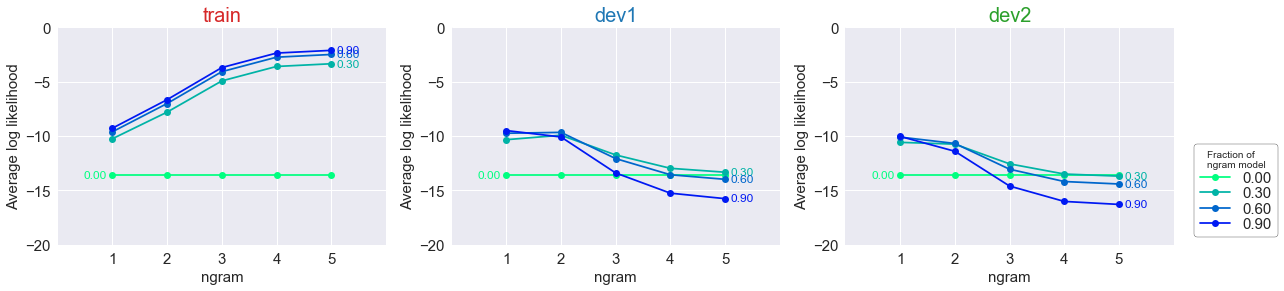

In [28]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 4))
text_locations_by_weight = {0: 'left', 0.3: 'right', 0.6: 'right', 0.9: 'right'}

for ngram_weight, text_location in text_locations_by_weight.items():
    plot_interpolate_with_uniform(ax1, train_prob_matrix, ngram_weight=ngram_weight, text_location=text_location, show_legend=False)
    plot_interpolate_with_uniform(ax2, dev1_prob_matrix, ngram_weight=ngram_weight, text_location=text_location, show_legend=False)
    plot_interpolate_with_uniform(ax3, dev2_prob_matrix, ngram_weight=ngram_weight, text_location=text_location)
    
ax1.set_title('train', color='tab:red')
ax2.set_title('dev1', color='tab:blue')
ax3.set_title('dev2', color='tab:green')

In [49]:
ngram_weight = 0.1
uniform_weight = 1 - ngram_weight
dev1_n_tokens = len(dev1_prob_matrix)
dev2_n_tokens = len(dev2_prob_matrix)

dev1_avg_lls = []
dev1_new_ngram_fractions = []
dev2_avg_lls = []
dev2_new_ngram_fractions = []

for n in range(1, 6):
    dev1_new_ngram_fractions.append((dev1_prob_matrix[:, n]==0).sum() / dev1_n_tokens)
    dev2_new_ngram_fractions.append((dev2_prob_matrix[:, n]==0).sum() / dev2_n_tokens)
    dev1_avg_lls.append(calculate_avg_ll(dev1_prob_matrix, [0, n], weights=[uniform_weight, ngram_weight]))
    dev2_avg_lls.append(calculate_avg_ll(dev2_prob_matrix, [0, n], weights=[uniform_weight, ngram_weight]))

Text(0, 0.5, 'Average log likelihood')

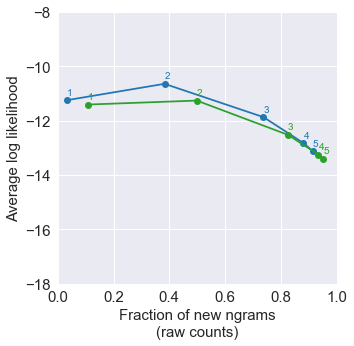

In [50]:
fig, ax = plt.subplots(figsize=(5, 5))

ax.plot(dev1_new_ngram_fractions, dev1_avg_lls, 'o-', color='tab:blue', clip_on=False)
ax.plot(dev2_new_ngram_fractions, dev2_avg_lls, 'o-', color='tab:green', clip_on=False)

for n in range(1, 6):
    ax.text(dev1_new_ngram_fractions[n-1], dev1_avg_lls[n-1]+0.2, s=n, color='tab:blue')
    ax.text(dev2_new_ngram_fractions[n-1], dev2_avg_lls[n-1]+0.2, s=n, color='tab:green')

ax.set_xlim(0, 1)
ax.set_ylim(-18, -8)
ax.set_xlabel('Fraction of new ngrams\n(raw counts)')
ax.set_ylabel('Average log likelihood')

Combine models sequentially

In [31]:
train_avg_lls = []
dev1_avg_lls = []
dev2_avg_lls = []
labels = ['0\n(uniform)']
label = ''

ngrams = []
for n in range(6):
    ngrams.append(n)
    train_avg_lls.append(calculate_avg_ll(train_prob_matrix, ngrams))
    dev1_avg_lls.append(calculate_avg_ll(dev1_prob_matrix, ngrams))
    dev2_avg_lls.append(calculate_avg_ll(dev2_prob_matrix, ngrams))
    
    label += f'{n}\n'
    labels.append(label)

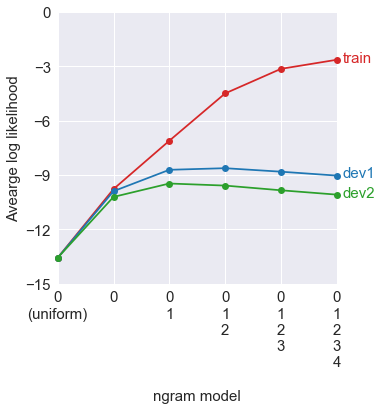

In [32]:
fig, ax = plt.subplots(figsize=(5, 5))

ax.plot(ngrams, train_avg_lls, '-o', color='tab:red', clip_on=False)
ax.plot(ngrams, dev1_avg_lls, '-o', color='tab:blue', clip_on=False)
ax.plot(ngrams, dev2_avg_lls, '-o', color='tab:green', clip_on=False)

ax.text(5.1, train_avg_lls[-1]+0.1, s='train', va='center', color='tab:red', fontsize=15)
ax.text(5.1, dev1_avg_lls[-1]+0.1, s='dev1', va='center', color='tab:blue', fontsize=15)
ax.text(5.1, dev2_avg_lls[-1]+0.1, s='dev2', va='center', color='tab:green', fontsize=15)

ax.set_xticklabels(labels)
ax.set_xlabel('ngram model')
ax.set_ylabel('Avearge log likelihood')
ax.set_xlim(0, 5)
ax.set_ylim(-15, 0)
ax.set_yticks(range(-15, 1, 3))
plt.show()